In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# example_points = np.random.rand(5) * 10
example_points = np.array([4.9639477 , 4.84066178, 4.32653559, 9.28842592, 5.74906772])


In [4]:
example_points

array([4.9639477 , 4.84066178, 4.32653559, 9.28842592, 5.74906772])

In [5]:
class RBF():
    def __init__(self, sigma0, sigmasquared):
        self.sigma0 = sigma0
        self.sigmasquared = sigmasquared

    def r_squared(self, obs, obsprime):
        mgx, mgy = np.meshgrid(obs, obsprime)
        return (mgx - mgy) **2 / self.sigmasquared

    def k(self, obs, obsprime=None):
        if obsprime is None:
            return_mat = self.sigma0 * np.exp(-0.5 * self.r_squared(obs, obs))
            n = len(obs)
            return return_mat + (10 ** -10 * np.eye(n))
        return self.sigma0 * np.exp(-0.5 * self.r_squared(obs, obsprime))

In [6]:
def objective(x):
 return np.sin(x) + np.sin((10.0 / 3.0) * x)

In [7]:
class GaussianProcess():
    def __init__(self, kernel, xdims = 1, meanfunc = lambda x: 0, x_obs=None, y_obs=None):
        self.meanfunc = meanfunc
        self.kernel = kernel
        self.x_obs = x_obs
        self.y_obs = y_obs

    def sample_prior(self, x):
        rng = np.random.default_rng()
        return rng.multivariate_normal(np.array([self.meanfunc(x) for x in x]), self.kernel.k(x))

    def posterior_means(self, x):
        return np.reshape(np.array([self.meanfunc(x) for x in x]), (len(x),1)) + self.kernel.k(self.x_obs, x) @ np.linalg.inv(self.kernel.k(self.x_obs)) @  np.reshape(self.y_obs - np.array([self.meanfunc(x) for x in self.x_obs]), (len(self.y_obs), 1))

    def posterior_covariance(self, x):
        return self.kernel.k(x) - (self.kernel.k(self.x_obs, x) @ np.linalg.inv(self.kernel.k(self.x_obs)) @ self.kernel.k(x, self.x_obs))
        
    def sample_posterior(self, x, size=None):
        rng = np.random.default_rng()
        return rng.multivariate_normal(self.posterior_means(x).reshape(len(x)), self.posterior_covariance(x), size)

    def best_point_obs(self):
        i = np.argmin(self.y_obs)
        return (self.x_obs[i], self.y_obs[i])

    def set_pending(self, x):
        self.x_pending = x

    def set_fantasies(self, n):
        self.fantasy_samples = self.sample_posterior(self.x_pending, n)

    def set_fantasy_gps(self):
        new_x = np.concatenate([self.x_obs, self.x_pending])
        self.fantasy_gps = []
        for s in self.fantasy_samples:
            new_y = np.concatenate([self.y_obs, s])
            self.fantasy_gps.append(GaussianProcess(self.kernel, x_obs = new_x, y_obs = new_y))


In [8]:
mykernel = RBF(1, 0.2)
mygp = GaussianProcess(mykernel)

mygp.x_obs = example_points
mygp.y_obs = objective(example_points)

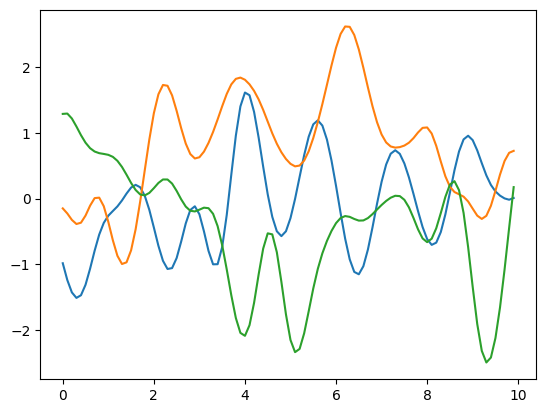

In [9]:
x = [i/10 for i in range(0,100)]
prior_sample_1 = mygp.sample_prior(x)
prior_sample_2 = mygp.sample_prior(x)
prior_sample_3 = mygp.sample_prior(x)


plt.plot(x, prior_sample_1, x, prior_sample_2, x, prior_sample_3)
plt.show()

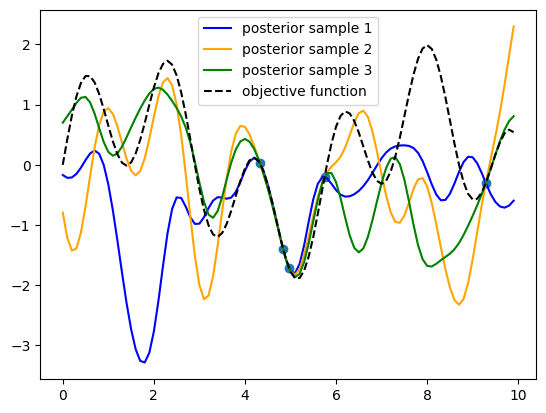

In [10]:
x = [i/10 for i in range(0,100)]

posterior_sample_1 = mygp.sample_posterior(x)
posterior_sample_2 = mygp.sample_posterior(x)
posterior_sample_3 = mygp.sample_posterior(x)
objective_lin = objective(np.array(x))

fig, ax = plt.subplots()
ax.plot(x, posterior_sample_1, color='blue', label='posterior sample 1')
ax.plot(x, posterior_sample_2, color='orange', label='posterior sample 2')
ax.plot(x, posterior_sample_3, color='green', label='posterior sample 3')
ax.plot(x, objective_lin, color='black', label='objective function', linestyle='--')

ax.scatter(mygp.x_obs, mygp.y_obs)


plt.legend()
plt.show()

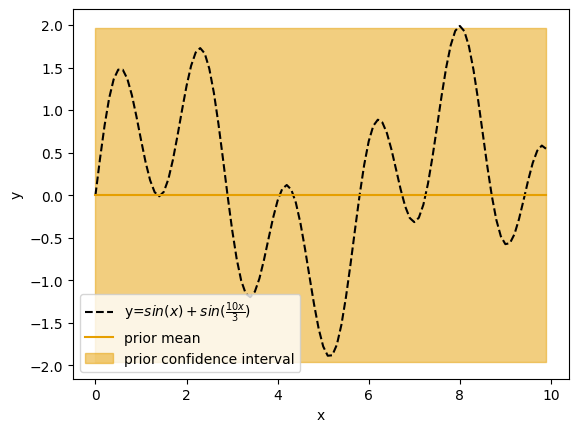

In [11]:
prior_means = [mygp.meanfunc(x) for x in x]
prior_var = mygp.kernel.k(x).diagonal()
ucb_prior = prior_means + ((prior_var **0.5) * 1.96)
lcb_prior = prior_means - ((prior_var **0.5) * 1.96)

posterior_means = mygp.posterior_means(x).flatten()
posterior_var = mygp.posterior_covariance(x).diagonal()
ucb_posterior = posterior_means + ((posterior_var **0.5) * 1.96)
lcb_posterior = posterior_means - ((posterior_var **0.5) * 1.96)

fig, ax = plt.subplots()
ax.plot(x, objective_lin, color='black', label= r"y=$sin(x)+sin(\frac{10x}{3})$", linestyle='--')
ax.plot(x, prior_means, color='#E69F00', label='prior mean', linestyle='-')
ax.fill_between(x, ucb_prior, lcb_prior, alpha=0.5, color='#E69F00', label='prior confidence interval')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("prior.png")
plt.show()

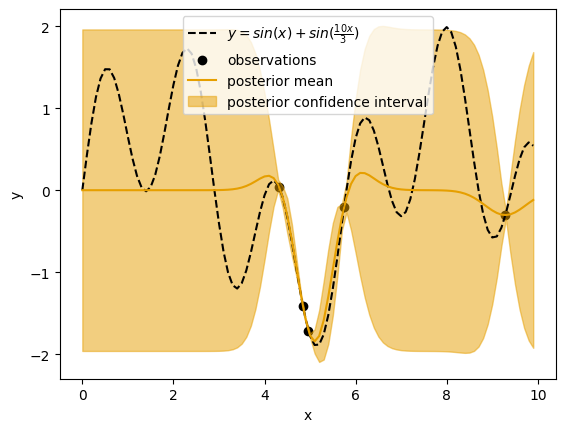

In [12]:
fig, ax = plt.subplots()
ax.plot(x, objective_lin, color='black', label= r"$y=sin(x)+sin(\frac{10x}{3})$", linestyle='--')
ax.scatter(mygp.x_obs, mygp.y_obs, color='black', label='observations')
ax.plot(x, posterior_means, color='#E69F00', label='posterior mean', linestyle='-')
ax.fill_between(x, ucb_posterior, lcb_posterior, alpha=0.5, color='#E69F00', label='posterior confidence interval')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("posterior.png")
plt.show()

In [13]:
# only works for univariate
def expected_improvement(x, gp):
    mean = gp.posterior_means([x])
    sdv = gp.posterior_covariance([x]) ** 0.5
    gamma = ((gp.best_point_obs()[1] - mean)/sdv).flatten()[0]
    
    g = norm.pdf(gamma)
    c = norm.cdf(gamma)
    return (c*gamma + g) * sdv.flatten()[0]

def single_next_point(xarr, gp):
    exp = [expected_improvement(i, gp) for i in xarr]
    ind = np.argmax(exp)
    return xarr[ind]
    

In [14]:
def fantasy_expected_improvement(x, fantasy_gps):
    return np.mean([expected_improvement(x, gp) for gp in fantasy_gps])

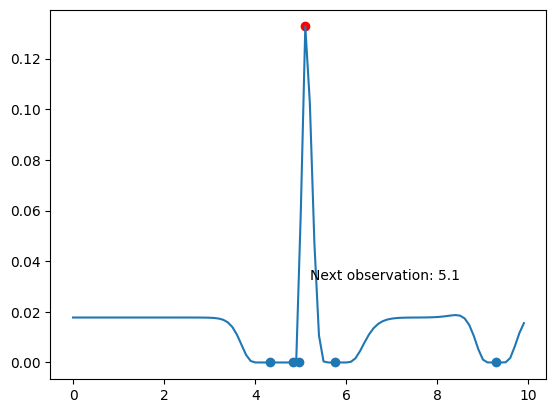

In [62]:
fig, ax = plt.subplots()
expected_improvement_vals = [expected_improvement(i, mygp) for i in x]
ax.plot(x, expected_improvement_vals)
ax.scatter(mygp.x_obs, np.zeros(len(mygp.x_obs)))
bpi = np.argmax(expected_improvement_vals)
ax.scatter(x[bpi], expected_improvement_vals[bpi], color='red')
ax.annotate("Next observation: {}".format(x[bpi]), (x[bpi] + 0.1, expected_improvement_vals[bpi] - 0.1))
plt.show()

In [63]:
newpoint = single_next_point(x, mygp)
new_observation = objective(newpoint)
estimate = mygp.posterior_means([newpoint]).flatten()[0]
print("new point: {} real value {} estimated value {}".format(newpoint, new_observation, estimate))

new point: 5.1 real value -1.8872121742072894 estimated value -1.8436929926191399


In [64]:
# Generate samples for pending points
mygp.set_pending([newpoint])
mygp.set_fantasies(200)
mygp.set_fantasy_gps()

In [65]:
new_obs_x = np.concatenate([mygp.x_obs, [newpoint]])
new_obs_y_real = np.concatenate([mygp.y_obs, [new_observation]])
new_obs_y_fantasy = np.concatenate([mygp.y_obs, [estimate]])
real_gp = GaussianProcess(mykernel)
# fantasy_gp = GaussianProcess(mykernel)

real_gp.x_obs = new_obs_x
real_gp.y_obs = new_obs_y_real

# fantasy_gp.x_obs = new_obs_x
# fantasy_gp.y_obs = new_obs_y_fantasy

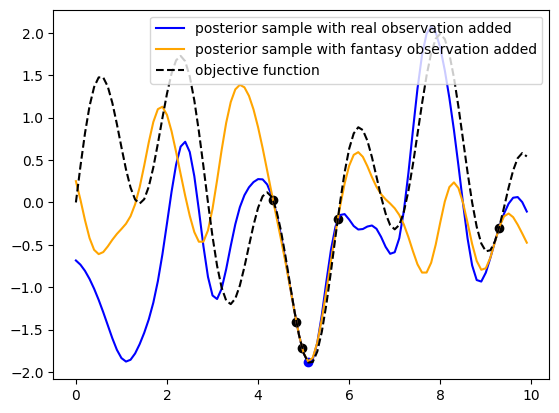

In [67]:
x = [i/10 for i in range(0,100)]

posterior_sample_real = real_gp.sample_posterior(x)
posterior_sample_fantasy = np.random.choice(mygp.fantasy_gps, 1)[0].sample_posterior(x)

objective_lin = objective(np.array(x))

fig, ax = plt.subplots()
ax.plot(x, posterior_sample_real, color='blue', label='posterior sample with real observation added')
ax.plot(x, posterior_sample_fantasy, color='orange', label='posterior sample with fantasy observation added')
ax.plot(x, objective_lin, color='black', label='objective function', linestyle='--')

ax.scatter(mygp.x_obs, mygp.y_obs, color='black')

ax.scatter(real_gp.x_obs[-1], real_gp.y_obs[-1], color='blue')
# ax.scatter(newpoint, estimate, color='orange')

plt.legend()
plt.show()

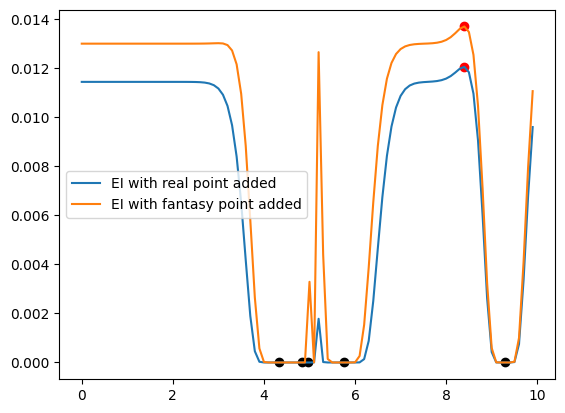

In [68]:
expected_improvement_real = [expected_improvement(i, real_gp) for i in x]
expected_improvement_fantasy = [fantasy_expected_improvement(i, mygp.fantasy_gps) for i in x]

fig, ax = plt.subplots()

ax.plot(x, expected_improvement_real, label='EI with real point added')
ax.plot(x, expected_improvement_fantasy, label='EI with fantasy point added')

ax.scatter(mygp.x_obs, np.zeros(len(mygp.x_obs)), color='black')

bpi_real = np.argmax(expected_improvement_real)
bpi_fantasy = np.argmax(expected_improvement_fantasy)

ax.scatter(x[bpi_real], expected_improvement_real[bpi_real], color='red')
ax.scatter(x[bpi_fantasy], expected_improvement_fantasy[bpi_fantasy], color='red')

ax.annotate("Next observation using real point: {}".format(x[bpi_real]), (x[bpi_real] + 0.1, expected_improvement_real[bpi_real] - 1))
ax.annotate("Next observation using fantasy point: {}".format(x[bpi_fantasy]), (x[bpi_fantasy] + 0.1, expected_improvement_real[bpi_fantasy] - 2))



plt.legend()
plt.show()

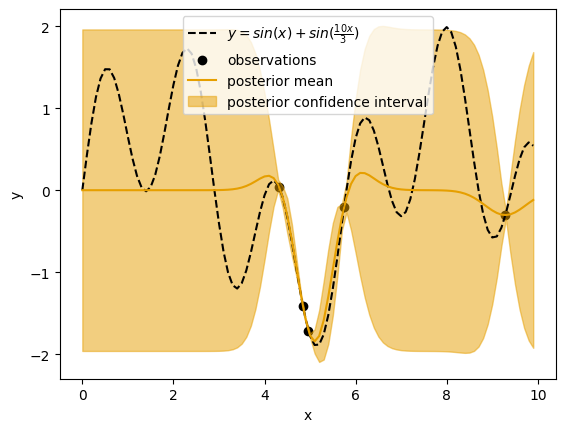

In [15]:
fig, ax = plt.subplots()
ax.plot(x, objective_lin, color='black', label= r"$y=sin(x)+sin(\frac{10x}{3})$", linestyle='--')
ax.scatter(mygp.x_obs, mygp.y_obs, color='black', label='observations')
ax.plot(x, posterior_means, color='#E69F00', label='posterior mean', linestyle='-')
ax.fill_between(x, ucb_posterior, lcb_posterior, alpha=0.5, color='#E69F00', label='posterior confidence interval')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
# plt.savefig("posterior.png")
plt.show()

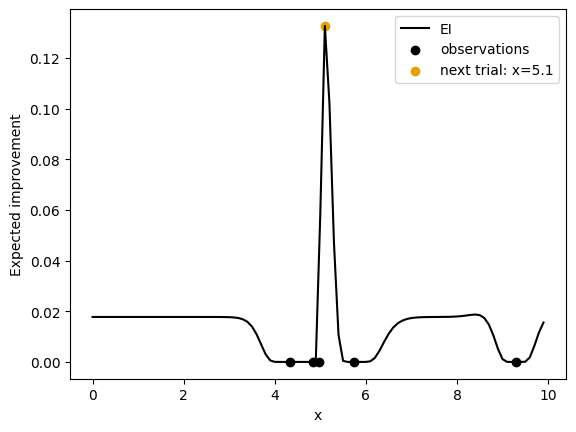

In [20]:
fig, ax = plt.subplots()
expected_improvement_vals = [expected_improvement(i, mygp) for i in x]
ax.plot(x, expected_improvement_vals, color='black', label='EI')
ax.scatter(mygp.x_obs, np.zeros(len(mygp.x_obs)), color='black', label='observations')
bpi = np.argmax(expected_improvement_vals)
ax.scatter(x[bpi], expected_improvement_vals[bpi], color='#E69F00', label="next trial: x={}".format(x[bpi]))
plt.xlabel("x")
plt.ylabel("Expected improvement")
plt.legend()
plt.savefig("ei.png")
plt.show()

In [24]:
mygp.fantasy_gps

AttributeError: 'GaussianProcess' object has no attribute 'fantasy_gps'

In [27]:
real_gps = []
fantasy_gps = []

In [28]:
# Gradually add real observations to mygp
def add_real_observation(gp, x):
    next_x = single_next_point(x, gp)
    next_y = objective(next_x)

    new_gp = GaussianProcess(gp.kernel)

    new_gp.x_obs = np.concatenate([gp.x_obs, [next_x]])
    new_gp.y_obs = np.concatenate([gp.y_obs, [next_y]])

    return new_gp

ngp = add_real_observation(mygp, x)
real_gps.append(ngp)
for i in range(4):
    ngp = add_real_observation(ngp, x)
    real_gps.append(ngp)


In [72]:
def plot_predictions(x, gp, savename=None):
    fig, ax = plt.subplots()
    ax.plot(x, objective_lin, color='black', label= r"$y=sin(x)+sin(\frac{10x}{3})$", linestyle='--')
    ax.scatter(gp.x_obs[:-1], gp.y_obs[:-1], color='black', label='observations')
    ax.scatter(gp.x_obs[-1], gp.y_obs[-1], color='black')

    posterior_means = gp.posterior_means(x).flatten()
    posterior_var = gp.posterior_covariance(x).diagonal()
    ucb_posterior = posterior_means + ((posterior_var **0.5) * 1.96)
    lcb_posterior = posterior_means - ((posterior_var **0.5) * 1.96)


    ax.plot(x, posterior_means, color='#E69F00', label='posterior mean', linestyle='-')
    ax.fill_between(x, ucb_posterior, lcb_posterior, alpha=0.5, color='#E69F00', label='posterior confidence interval')

    ax.scatter(gp.x_obs[-1], gp.y_obs[-1], color='black')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

    if savename:
        plt.savefig(savename)
    plt.show()

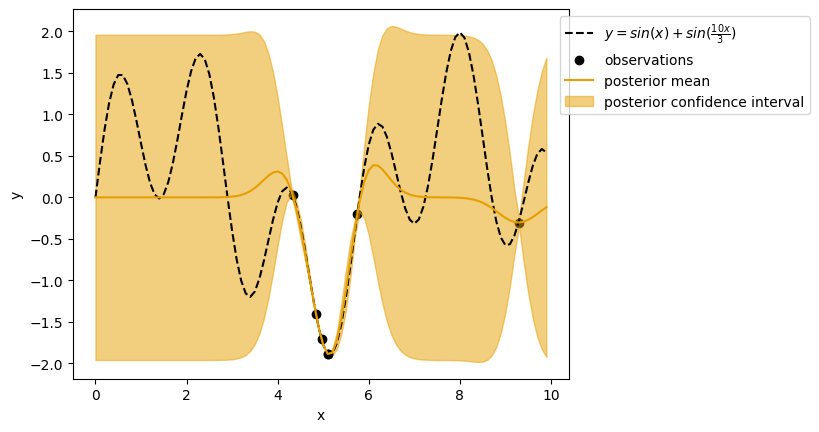

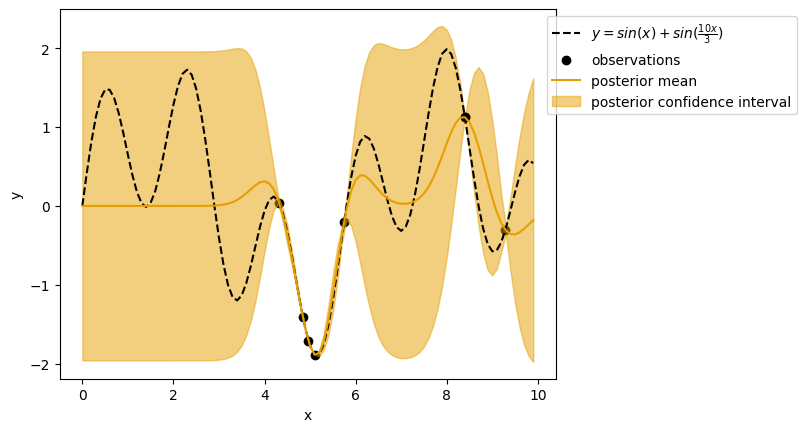

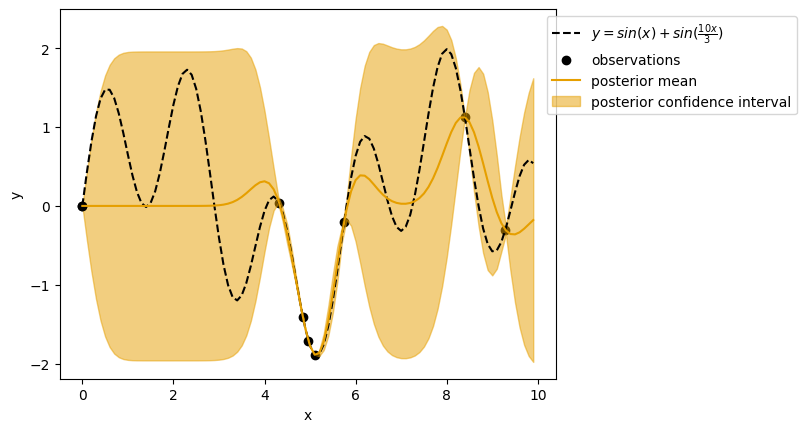

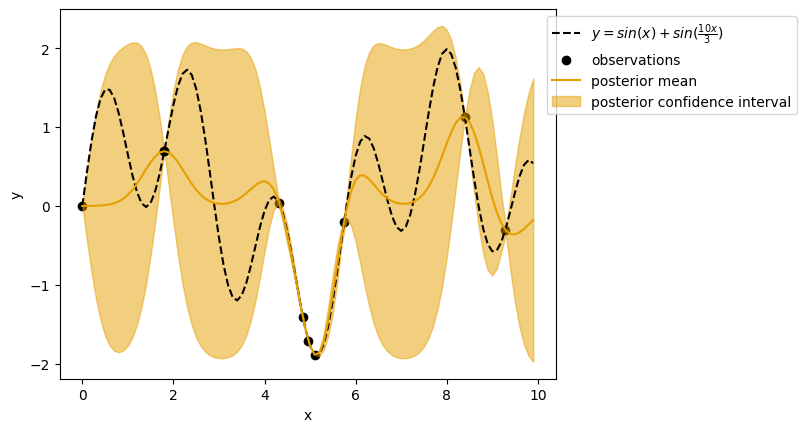

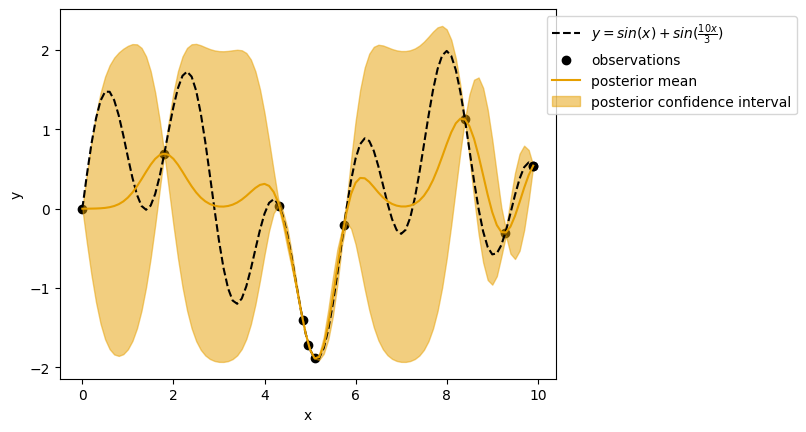

In [73]:
for gp_to_plot in real_gps:
# gp_to_plot = real_gps[0]
    plot_predictions(x, gp_to_plot, savename="posterior_real_{}.png".format(len(gp_to_plot.x_obs)))

In [74]:
def plot_ei(x, gp, savename=None):
    fig, ax = plt.subplots()
    expected_improvement_vals = [expected_improvement(i, gp) for i in x]
    ax.plot(x, expected_improvement_vals, color='black', label='EI')
    ax.scatter(gp.x_obs, np.zeros(len(gp.x_obs)), color='black', label='observations')
    bpi = np.argmax(expected_improvement_vals)
    ax.scatter(x[bpi], expected_improvement_vals[bpi], color='#E69F00', label="next trial: x={}".format(x[bpi]))
    plt.xlabel("x")
    plt.ylabel("Expected improvement")
    plt.legend()
    if savename:
        plt.savefig(savename)
    plt.show()

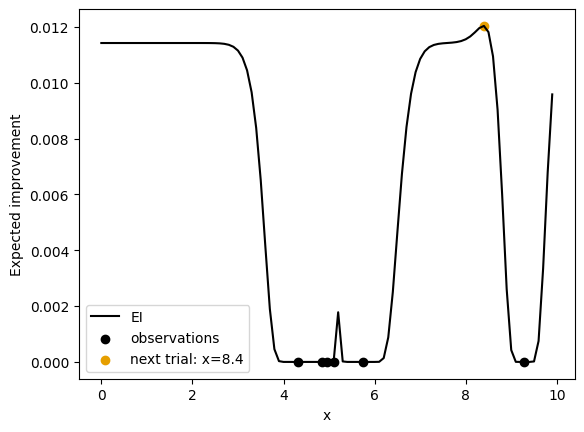

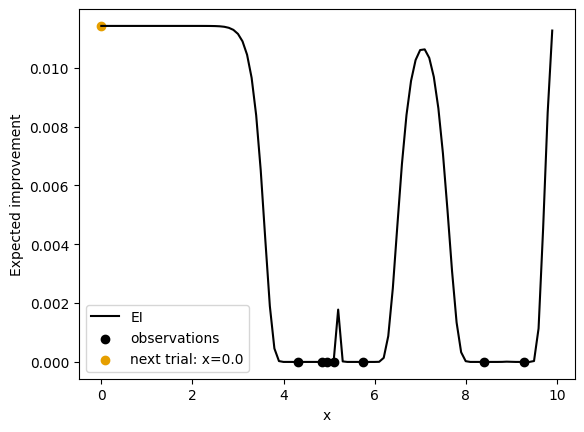

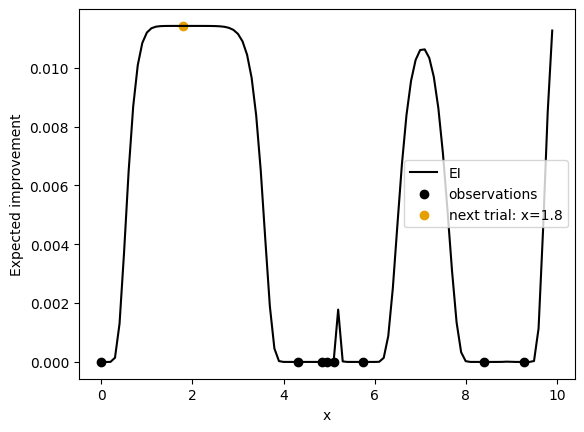

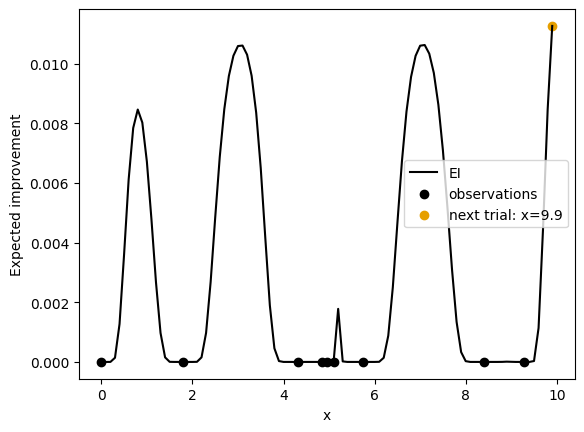

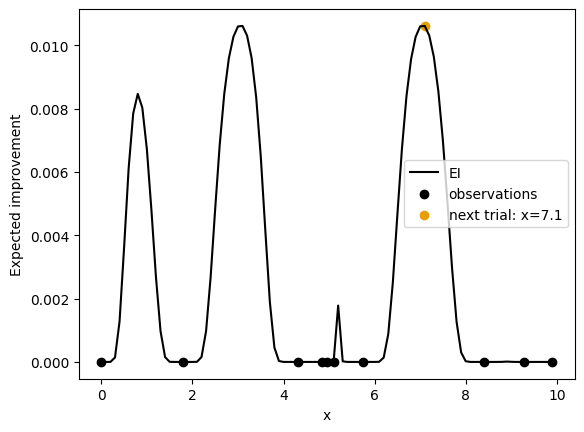

In [75]:
for gp_to_plot in real_gps:
    plot_ei(x, gp_to_plot, savename="ei_real_{}.png".format(len(gp_to_plot.x_obs)))